# **Trabajo práctico final**

El objetivo de este trabajo es analizar cómo afectan los neumáticos y el combustible en los tiempos de vuelta de los pilotos durante el Gran Premio de Estados Unidos en Austin, una  carrera de fórmula 1. En particular, se busca determinar si los pilotos logran mejores tiempos con neumáticos Medium o Hard, considerando también el efecto de la disminución de peso del auto a medida que se consume combustible. Para esto, se emplearán tres enfoques metodológicos:
* Un modelo lineal generalizado (GLM) frecuentista.
* Un GLM bayesiano.
* Un test de hipótesis.



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import numpy as np
import scipy.stats as stats


# **Carga y procesamiento de los datos**

In [4]:
df = pd.read_csv('usgp.csv')
df = df[df['Compound'] != 'SOFT']
df = df.drop(columns=['Driver'])
df['LapTime'] = pd.to_timedelta(df['LapTime'])
df['LapTime'] = df['LapTime'].dt.total_seconds()

df = df.dropna(subset=['Compound', 'LapTime'])
df['Compound'] = df['Compound'].map({'MEDIUM': 0, 'HARD': 1})
df_medium = df[df['Compound'] == 0]
df_hard = df[df['Compound'] == 1]

df_hard.info()
print(df_hard.head())
df_medium.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536 entries, 20 to 936
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  536 non-null    int64  
 1   Compound    536 non-null    int64  
 2   LapNumber   536 non-null    float64
 3   LapTime     536 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 20.9 KB
    Unnamed: 0  Compound  LapNumber  LapTime
20          26         1       27.0   99.046
21          27         1       28.0   98.784
22          28         1       29.0   99.067
23          29         1       30.0   98.750
24          30         1       31.0   99.058
<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 0 to 913
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  398 non-null    int64  
 1   Compound    398 non-null    int64  
 2   LapNumber   398 non-null    float64
 3   LapTime     398 non-null

Luego de procesar los datos, nos quedamos con tres datasets distintos.



* df: datos de ambos neumáticos.
    - columnas:
      - Compound (tipo de neumático: hard o medium).
      - LapTime:(tiempo de vuelta en segundos).
      - LapNumber(número de vuelta).
    - 934 filas.

* df_hard: Nos quedamos solo con las filas que corresponden al neúmatico hard.
* df_medium: Nos quedamos solo con las filas que corresponden al neúmatico medium.











# **Análisis exploratorio de datos**

Primero decidí ver la distribucion de los neumáticos segun el número y el tiempo de vuelta.

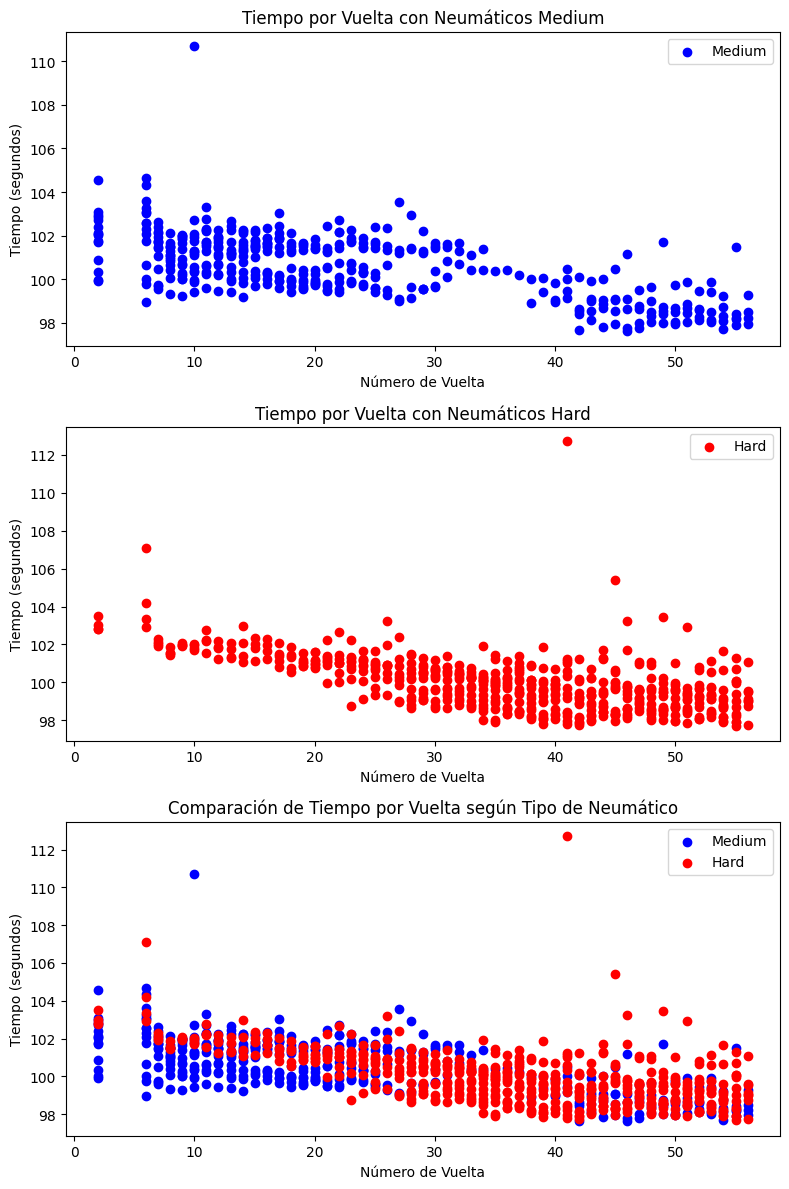

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))


axs[0].scatter(df_medium['LapNumber'], df_medium['LapTime'], color='blue', label='Medium')
axs[0].set_xlabel('Número de Vuelta')
axs[0].set_ylabel('Tiempo (segundos)')
axs[0].set_title('Tiempo por Vuelta con Neumáticos Medium')
axs[0].legend()

axs[1].scatter(df_hard['LapNumber'], df_hard['LapTime'], color='red', label='Hard')
axs[1].set_xlabel('Número de Vuelta')
axs[1].set_ylabel('Tiempo (segundos)')
axs[1].set_title('Tiempo por Vuelta con Neumáticos Hard')
axs[1].legend()


axs[2].scatter(df_medium['LapNumber'], df_medium['LapTime'], color='blue', label='Medium')
axs[2].scatter(df_hard['LapNumber'], df_hard['LapTime'], color='red', label='Hard')
axs[2].set_xlabel('Número de Vuelta')
axs[2].set_ylabel('Tiempo (segundos)')
axs[2].set_title('Comparación de Tiempo por Vuelta según Tipo de Neumático')
axs[2].legend()

plt.tight_layout()
plt.show()

**Interpretación:** Podemos observar que en ambos casos hay una disminución en el tiempo a medida que las vueltas aumentan, indicando una tendencia lineal.

Para terminar con el análisis exploratorio, voy a  hacer un histograma para comparar los tiempos de vuelta entre los neumáticos Medium y Hard, mostrando las distribuciones y las medias de ambos.

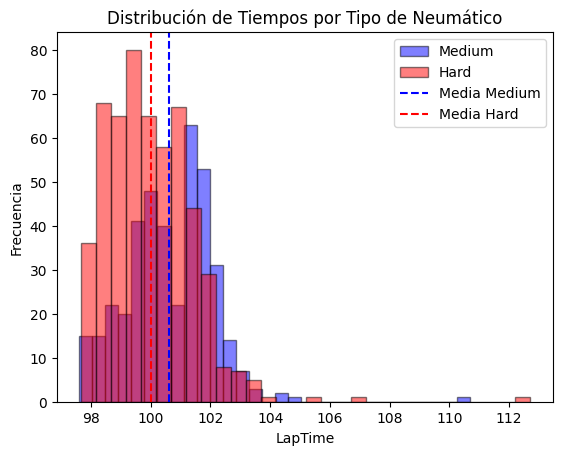

In [6]:
medium_times = df_medium['LapTime'].values
hard_times = df_hard['LapTime'].values

plt.hist(medium_times, bins=30, alpha=0.5, label='Medium', color='blue', edgecolor='black')
plt.hist(hard_times, bins=30, alpha=0.5, label='Hard', color='red', edgecolor='black')
plt.axvline(np.mean(medium_times), color='blue', linestyle='--', label='Media Medium')
plt.axvline(np.mean(hard_times), color='red', linestyle='--', label='Media Hard')
plt.title('Distribución de tiempos por tipo de Neumático')
plt.xlabel('LapTime')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

**Interpretación:** En el gráfico se puede observar que los tiempos de vuelta para los neumáticos Medium tienen una media más alta que los tiempos de vuelta para los neumáticos Hard.

**¿Ésta diferencia es signifactiva?**


# **Test de hipótesis**

En este análisis, queremos determinar si existe una diferencia significativa entre los tiempos medios de vuelta para los neumáticos Medium y Hard. Para ello, realizamos un test t de Student para muestras independientes, que es una prueba estadística adecuada para comparar las medias de dos grupos.

**Hipótesis planteadas:**

* Hipótesis nula: Las medias de los tiempos de vuelta para los neumáticos Medium y Hard son iguales.

* Hipótesis alternativa: Las medias de los tiempos de vuelta para los neumáticos Medium y Hard son diferentes.


Nuestro nivel de significancia será 0.05.



In [7]:
media_medium = np.mean(medium_times)
media_hard = np.mean(hard_times)
std_medium = np.std(medium_times, ddof=1)
std_hard = np.std(hard_times, ddof=1)
n_medium = len(medium_times)
n_hard = len(hard_times)

varianza_agrupada = ((n_medium - 1) * std_medium**2 + (n_hard - 1) * std_hard**2) / (n_medium + n_hard - 2)

t_stat = (media_medium - media_hard) / np.sqrt(varianza_agrupada* (1/n_medium + 1/n_hard))

gl = n_medium + n_hard - 2

p_valor = 2 * stats.t.sf(np.abs(t_stat), gl)

print("Valor p: ", p_valor)

Valor p:  4.963061353796638e-11


Dado que el valor-p ( 4.96 × 10⁻¹¹) es menor que el nivel de significancia (0,05) rechazamos la hipótesis nula. Esto significa que hay evidencia estadística suficiente para afirmar que los tiempos promedio de vuelta con neumáticos Medium y Hard no son  iguales.

# **Análisis frecuentista**

En este análisis, opté por construir dos modelos separados, uno para cada tipo de neumático: Medium y Hard. Esto me permitió analizar de forma independiente cómo evolucionan los tiempos de vuelta en función del número de vueltas para cada tipo de neumático.

Para cada conjunto de datos (Medium y Hard), realicé una regresión lineal simple, donde el tiempo de vuelta (y) fue modelado como una función lineal del número de vuelta (x):

y = a + b⋅x + e

Acá:

* **a** es el intercepto o el tiempo estimado en la vuelta inicial.

* **b** es el coeficiente asociado al número de vuelta, que indica cómo cambia el tiempo de vuelta en promedio con cada vuelta adicional.

* **e** representa el término de error.


In [ ]:
#modelo frecuentista para medium
X_medium = np.array(df_medium[['LapNumber']])
X_medium = np.column_stack((np.ones(len(X_medium)), X_medium))
y_medium = np.array(df_medium['LapTime'])

beta_hat_medium = np.linalg.inv(X_medium.T @ X_medium) @ X_medium.T @ y_medium

residuos_medium = y_medium - X_medium @ beta_hat_medium

mse_medium = np.mean(residuos_medium**2)
rmse_medium = np.sqrt(mse_medium)


print("Coeficientes medium:", beta_hat_medium)
print("mse medium: ", mse_medium)
print("rmse medium: ", rmse_medium)

Coeficientes medium: [ 1.02066300e+02 -6.32143927e-02]
mse medium:  1.2230769791240463
rmse medium:  1.1059281075748306


In [ ]:
#modelo frecuentista para hard
X_hard = np.array(df_hard[['LapNumber']])
X_hard = np.column_stack((np.ones(len(X_hard)), X_hard))
y_hard = np.array(df_hard['LapTime'])

beta_hat_hard = np.linalg.inv(X_hard.T @ X_hard) @ X_hard.T @ y_hard

residuos_hard = y_hard - X_hard @ beta_hat_hard


mse_hard = np.mean(residuos_hard**2)
rmse_hard = np.sqrt(mse_hard)

print("Coeficientes hard:", beta_hat_hard)
print("mse hard: ", mse_hard)
print("rmse hard: ", rmse_hard)

Coeficientes hard: [ 1.02360436e+02 -6.61750114e-02]
mse hard:  1.3323314039810972
rmse hard:  1.154266608709226


**Interpretación de los resultados:**

* Ambos modelos tienen pendientes negativas (-6.32143927e-02 para Medium y -6.61750114e-02 para Hard), lo que significa que los tiempos de vuelta disminuyen a medida que avanzan las vueltas. Esto puede ser porque a medida que aumentan las vueltas la nafta disminuye y el vehiculo se vuelve mas liviano.

* Los valores de RMSE son similares (1.11 para Medium y 1.15 para Hard), lo que indica que ambos modelos tienen una precisión similar al predecir los tiempos de vuelta. Sin embargo, el error de medium es ligeramente menor, lo que sugiere que los datos están un poco mejor representados para este neumático.






**Gráfico de residuos**

 A continuación, construiremos un gráfico de residuos para analizar el desempeño de cada modelo.



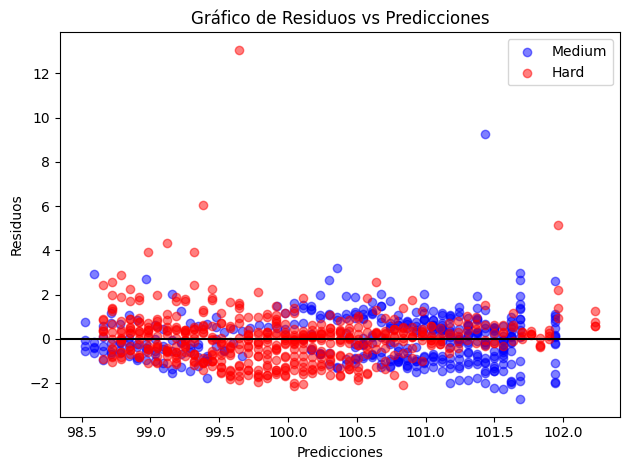

In [ ]:

predicciones_medium = X_medium @ beta_hat_medium

predicciones_hard = X_hard @ beta_hat_hard

plt.scatter(predicciones_medium, residuos_medium, color='blue', label='Medium', alpha=0.5)
plt.scatter(predicciones_hard, residuos_hard, color='red', label='Hard', alpha=0.5)
plt.axhline(y=0, color='black')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs Predicciones')

plt.legend()
plt.tight_layout()
plt.show()


**Interpretación:** Los modelos para ambos tipos de neumáticos parecen ajustarse bien a los datos, ya que los residuos están distribuidos de forma uniforme alrededor de cero y no muestran patrones que indiquen problemas en los modelos.


**Visualización de los modelos de regresión**


Vamos a graficar los tiempos de vuelta para ambos tipos de neumáticos (Medium y Hard) junto con las líneas de regresión obtenidas. Este gráfico nos permitirá observar cómo se ajustan los modelos a los datos y comparar las tendencias entre ambos tipos de neumáticos.








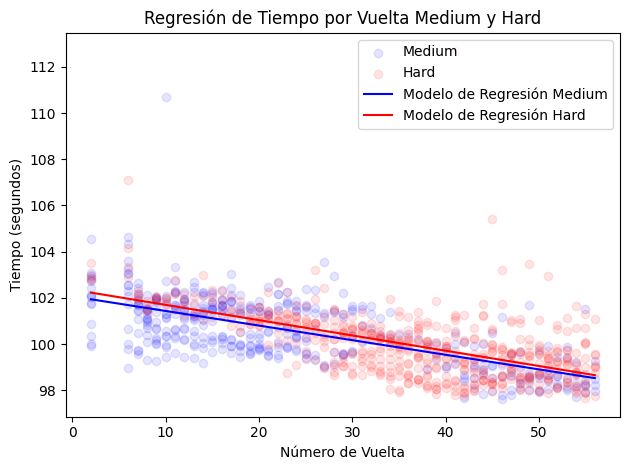

In [ ]:

plt.scatter(df_medium['LapNumber'], df_medium['LapTime'], color='blue', label='Medium', alpha=0.1)
plt.scatter(df_hard['LapNumber'], df_hard['LapTime'], color='red', label='Hard', alpha=0.1)

lap_numbers_medium = np.linspace(df_medium['LapNumber'].min(), df_medium['LapNumber'].max(), 100)
y_medium_line = beta_hat_medium[0] + beta_hat_medium[1] * lap_numbers_medium

lap_numbers_hard = np.linspace(df_hard['LapNumber'].min(), df_hard['LapNumber'].max(), 100)
y_hard_line = beta_hat_hard[0] + beta_hat_hard[1] * lap_numbers_hard

plt.plot(lap_numbers_medium, y_medium_line, color='blue', label='Modelo de Regresión Medium')
plt.plot(lap_numbers_hard, y_hard_line, color='red', label='Modelo de Regresión Hard')

plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo (segundos)')
plt.title('Regresión de Tiempo por Vuelta Medium y Hard')

plt.legend()
plt.tight_layout()
plt.show()


**Interpretación:** Ambas líneas tienen pendiente negativa, indicando que los tiempos disminuyen a medida que avanzan las vueltas. Sin embargo, se observa que los neumáticos Medium presentan un rendimiento ligeramente mejor (tiempos más bajos) en la mayor parte de las vueltas. Aunque esta diferencia es evidente al inicio, tiende a reducirse hacia las últimas vueltas, sugiriendo que los neumáticos Hard podrían cerrar esa brecha con el tiempo.

# **Análisis bayesiano**

En este análisis bayesiano, vamos a ajustar dos modelos de regresión lineales para comparar los tiempos de vuelta con neumáticos Medium y Hard a lo largo de las vueltas. El análisis se realizará utilizando PyMC.

Output()

Output()

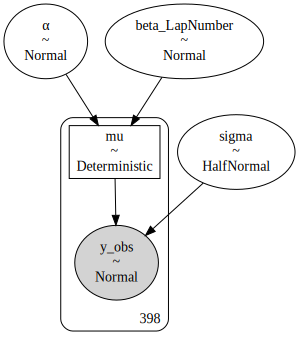

In [ ]:
# Modelo bayesiano para Medium
X_medium = df_medium[['LapNumber']]
y_medium = df_medium['LapTime']

with pm.Model() as modelo_medium:
    intercepto_medium = pm.Normal('α', mu=0, sigma=10)
    beta_LapNumber_medium = pm.Normal('beta_LapNumber', mu=0, sigma=10)
    sigma_medium = pm.HalfNormal('sigma', sigma=10)
    mu_medium = pm.Deterministic('mu', intercepto_medium + beta_LapNumber_medium * X_medium['LapNumber'])
    y_obs_medium = pm.Normal('y_obs', mu=mu_medium, sigma=sigma_medium, observed=y_medium)

    idata_medium = pm.sample(1000,random_seed=123)
pm.model_to_graphviz(modelo_medium)

Output()

Output()

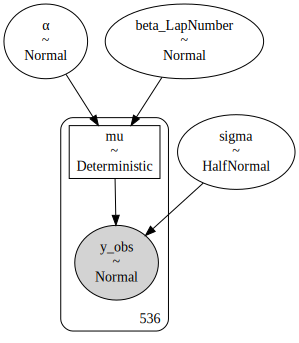

In [ ]:
# Modelo bayesiano para hard
X_hard = df_hard[['LapNumber']]
y_hard = df_hard['LapTime']

with pm.Model() as modelo_hard:
    intercepto_hard = pm.Normal('α', mu=0, sigma=10)
    beta_LapNumber_hard = pm.Normal('beta_LapNumber', mu=0, sigma=10)
    sigma_hard = pm.HalfNormal('sigma', sigma=10)
    mu_hard = pm.Deterministic('mu', intercepto_hard + beta_LapNumber_hard * X_hard['LapNumber'])
    y_obs_hard = pm.Normal('y_obs', mu=mu_hard, sigma=sigma_hard, observed=y_hard)

    idata_hard = pm.sample(1000,random_seed=123)
pm.model_to_graphviz(modelo_hard)

**Interpretacion:** Los modelos ajustan una regresión lineal, donde el intercepto y la pendiente se modelan con distribuciones normales. La desviación estándar de los errores se modela con una distribución HalfNormal. Los tiempos de vuelta observados se modelan como una distribución normal, donde la media es calculada usando el intercepto y la pendiente multiplicada por el número de vuelta. Los priors son relativamente no informativos.

A continuación, vamos a ver los traceplots para evaluar la convergencia de los parámetros en los modelos.

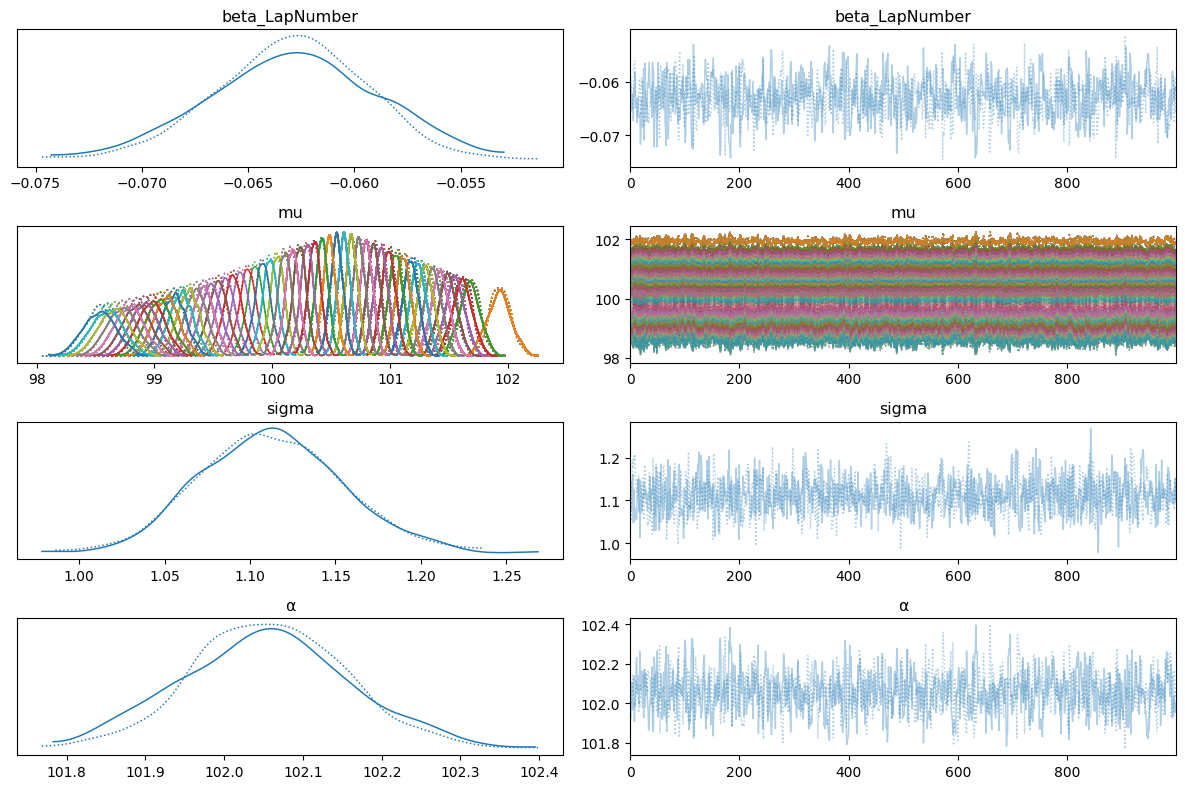

In [ ]:
with modelo_medium:
  az.plot_trace(idata_medium)
  plt.tight_layout()
  plt.show()

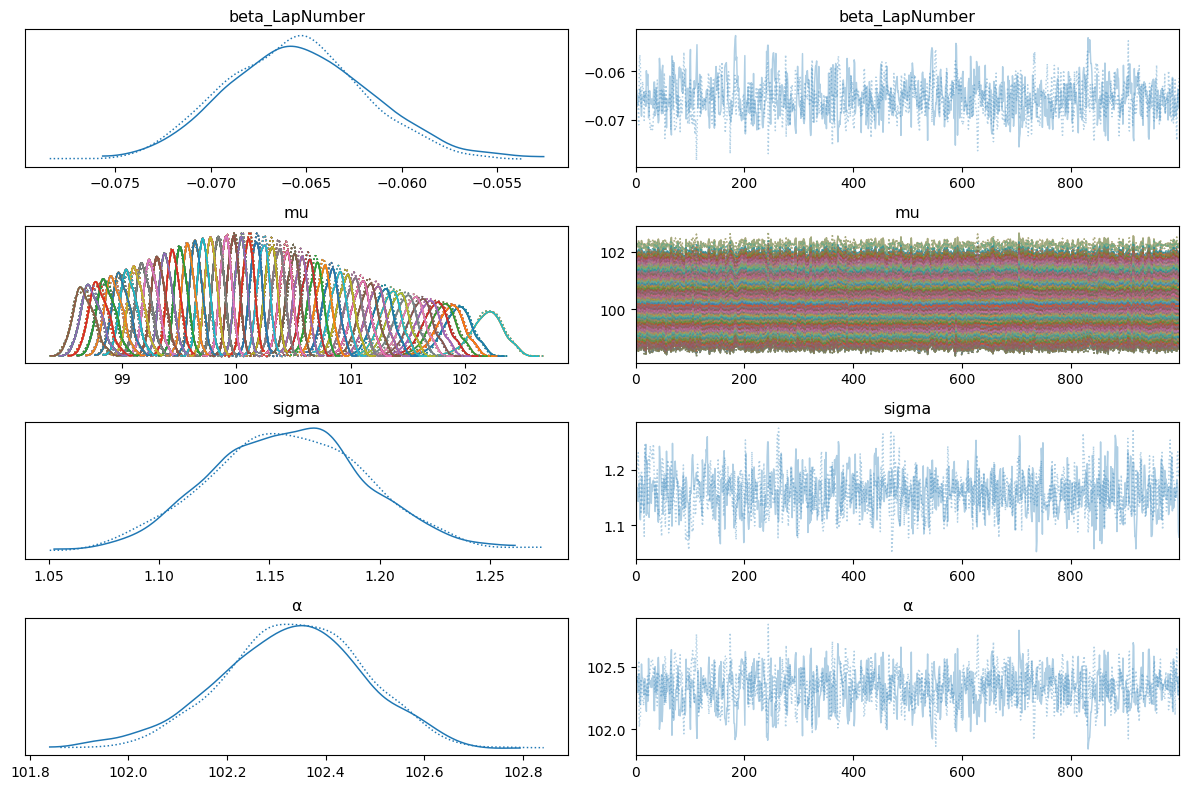

In [ ]:
with modelo_hard:
  az.plot_trace(idata_hard)
  plt.tight_layout()
  plt.show()

**Interpretación:** Al observar los traceplots, podemos ver que las dos cadenas de Markov tienen comportamientos similares y no muestran saltos bruscos, lo que indica una buena convergencia del modelo.

Ahora vamos a realizar el posterior predictive check. Este análisis nos ayudará a evaluar qué tan bien los modelos ajustan los datos reales y si nuestras predicciones son coherentes con las observaciones.

Output()

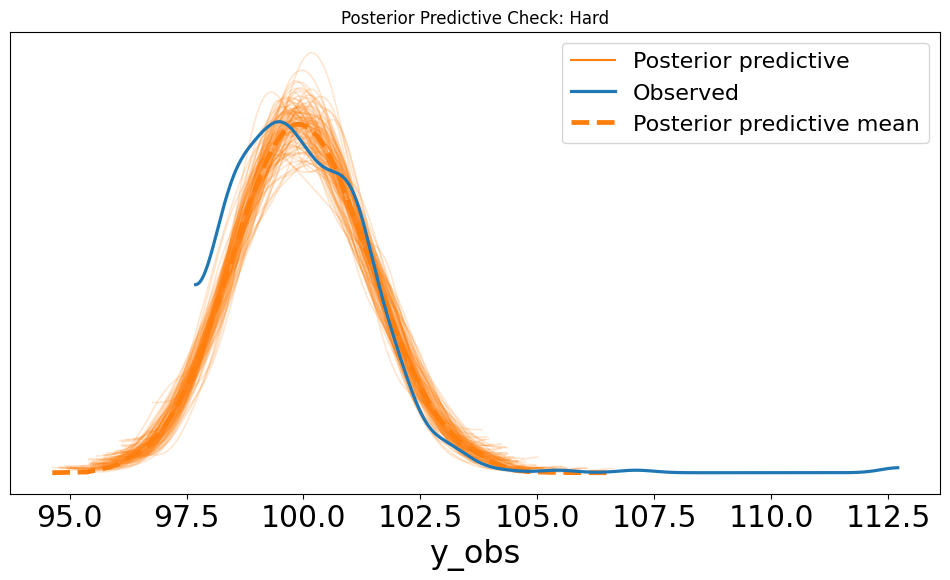

In [ ]:
with modelo_hard:
    idata_hard = pm.sample_posterior_predictive(idata_hard, model=modelo_hard, random_seed=2, extend_inferencedata=True)

az.plot_ppc(idata_hard, num_pp_samples=100, figsize=(12, 6), colors=["C1", "C0", "C1"])
plt.title("Posterior Predictive Check: Hard")
plt.show()

Output()

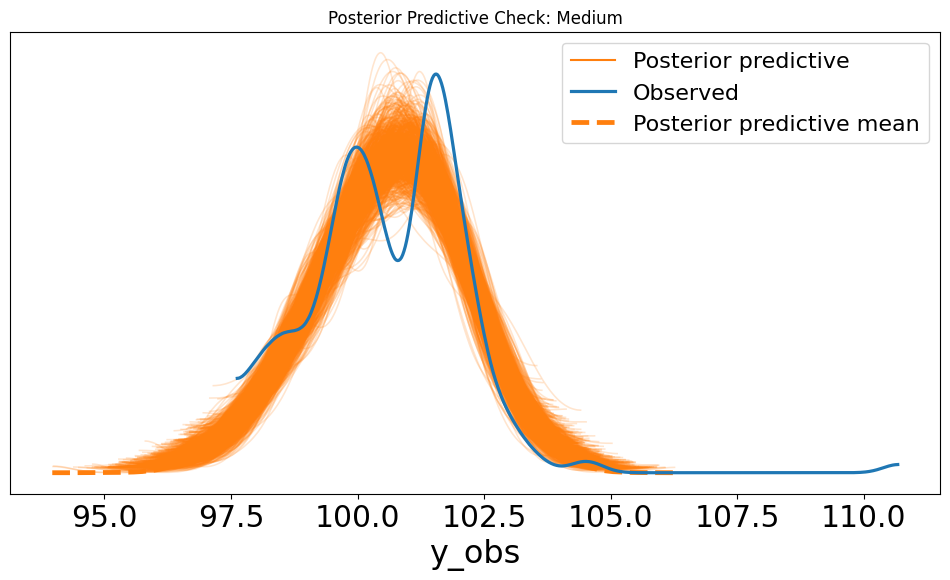

In [ ]:

with modelo_medium:
    idata_medium = pm.sample_posterior_predictive(idata_medium, model=modelo_medium, random_seed=2, extend_inferencedata=True)

az.plot_ppc(idata_medium, num_pp_samples=1000, figsize=(12, 6), colors=["C1", "C0", "C1"])
plt.title("Posterior Predictive Check: Medium")
plt.show()

**Interpretación:** En el caso de los neumáticos Hard, el modelo bayesiano ajusta bien los datos observados, el modelo los captura correctamente. Sin embargo, en el caso de los neumáticos Medium, hay problemas para capturar bien los datos debido a que los tiempos de los medium no parecen seguir una distribución normal.

Ahora vamos a mostrar un gráfico que compara las regresiones bayesianas para los neumáticos Medium y Hard, junto con los datos originales de los tiempos de vuelta.

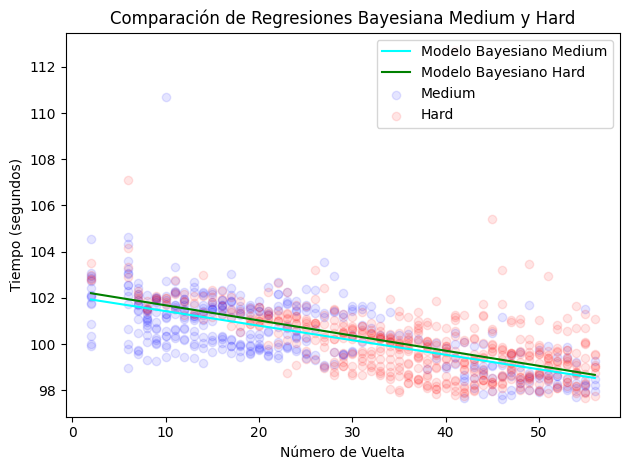

In [ ]:
intercepto_medium_mean = idata_medium.posterior['α'].mean(dim=['chain', 'draw']).values
beta_LapNumber_medium_mean = idata_medium.posterior['beta_LapNumber'].mean(dim=['chain', 'draw']).values

lap_numbers_medium = np.linspace(df_medium['LapNumber'].min(), df_medium['LapNumber'].max(), 100)
y_bayes_medium = intercepto_medium_mean + beta_LapNumber_medium_mean * lap_numbers_medium

intercepto_hard_mean = idata_hard.posterior['α'].mean(dim=['chain', 'draw']).values
beta_LapNumber_hard_mean = idata_hard.posterior['beta_LapNumber'].mean(dim=['chain', 'draw']).values

lap_numbers_hard = np.linspace(df_hard['LapNumber'].min(), df_hard['LapNumber'].max(), 100)
y_bayes_hard = intercepto_hard_mean + beta_LapNumber_hard_mean * lap_numbers_hard

plt.plot(lap_numbers_medium, y_bayes_medium, color='cyan', label='Modelo Bayesiano Medium')
plt.plot(lap_numbers_hard, y_bayes_hard, color='green', label='Modelo Bayesiano Hard')

plt.scatter(df_medium['LapNumber'], df_medium['LapTime'], color='blue', label='Medium', alpha=0.1)
plt.scatter(df_hard['LapNumber'], df_hard['LapTime'], color='red', label='Hard', alpha=0.1)

plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de Regresiones Bayesiana Medium y Hard')

plt.legend()

plt.tight_layout()
plt.show()

**Interpretación:** Los resultados son similares al modelo frecuentista. Ambas líneas tienen pendiente negativa y se observa que los neumáticos Medium presentan un rendimiento ligeramente mejor, aunque esta diferencia va disminuyendo con el aumento de las vueltas.

Para evaluar mejor la variabilidad en las predicciones y la incertidumbre del modelo, vamos a analizar los percentiles del 2.5% y 97.5% de las distribuciones posteriores

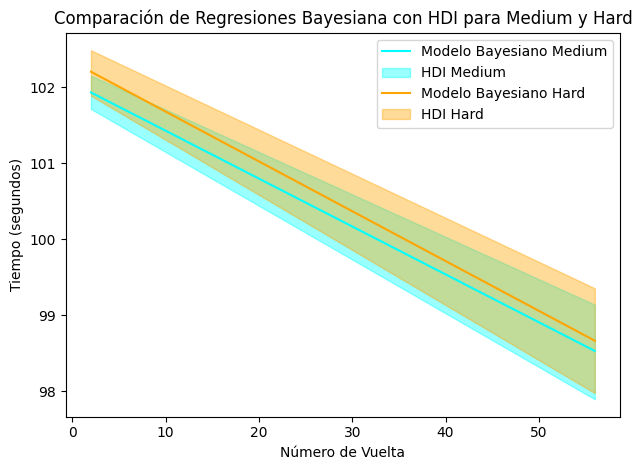

In [ ]:

alpha_medium_samples = idata_medium.posterior['α'].values
beta_LapNumber_medium_samples = idata_medium.posterior['beta_LapNumber'].values

alpha_hard_samples = idata_hard.posterior['α'].values
beta_LapNumber_hard_samples = idata_hard.posterior['beta_LapNumber'].values

alpha_medium_hdi = np.percentile(alpha_medium_samples, [2.5, 97.5], axis=(0, 1))
beta_LapNumber_medium_hdi = np.percentile(beta_LapNumber_medium_samples, [2.5, 97.5], axis=(0, 1))

alpha_hard_hdi = np.percentile(alpha_hard_samples, [2.5, 97.5], axis=(0, 1))
beta_LapNumber_hard_hdi = np.percentile(beta_LapNumber_hard_samples, [2.5, 97.5], axis=(0, 1))

y_bayes_medium_lower = alpha_medium_hdi[0] + beta_LapNumber_medium_hdi[0] * lap_numbers_medium
y_bayes_medium_upper = alpha_medium_hdi[1] + beta_LapNumber_medium_hdi[1] * lap_numbers_medium

y_bayes_hard_lower = alpha_hard_hdi[0] + beta_LapNumber_hard_hdi[0] * lap_numbers_hard
y_bayes_hard_upper = alpha_hard_hdi[1] + beta_LapNumber_hard_hdi[1] * lap_numbers_hard

plt.plot(lap_numbers_medium, y_bayes_medium, color='cyan', label='Modelo Bayesiano Medium')
plt.fill_between(lap_numbers_medium, y_bayes_medium_lower, y_bayes_medium_upper, color='cyan', alpha=0.4, label='HDI Medium')

plt.plot(lap_numbers_hard, y_bayes_hard, color='orange', label='Modelo Bayesiano Hard')
plt.fill_between(lap_numbers_hard, y_bayes_hard_lower, y_bayes_hard_upper, color='orange', alpha=0.4, label='HDI Hard')

# plt.scatter(df_medium['LapNumber'], df_medium['LapTime'], color='blue', label='Medium', alpha=0.3)
# plt.scatter(df_hard['LapNumber'], df_hard['LapTime'], color='red', label='Hard', alpha=0.3)

plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de Regresiones Bayesiana con HDI para Medium y Hard')

plt.legend()
plt.tight_layout()
plt.show()


**Interpretación:** Aún con la varianza que uno se espera en el modelo, en general hay una diferencia entre los rendimientos de cada neumático.

Por último, vamos a generar un gráfico que compare las líneas de regresión obtenidas mediante el modelo bayesiano con las que obtuvimos utilizando el enfoque frecuentista.

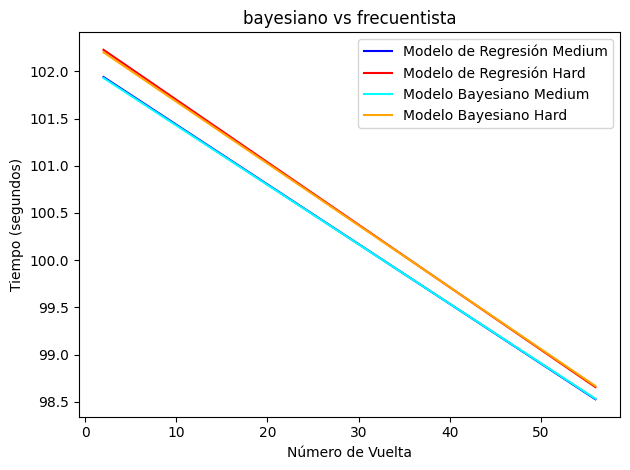

In [ ]:

#plt.scatter(df_medium['LapNumber'], df_medium['LapTime'], color='blue', label='Medium', alpha=0.3)
#plt.scatter(df_hard['LapNumber'], df_hard['LapTime'], color='red', label='Hard', alpha=0.3)
plt.plot(lap_numbers_medium, y_medium_line, color='blue', label='Modelo de Regresión Medium')
plt.plot(lap_numbers_hard, y_hard_line, color='red', label='Modelo de Regresión Hard')
plt.plot(lap_numbers_medium, y_bayes_medium, color='cyan', label='Modelo Bayesiano Medium')
plt.plot(lap_numbers_hard, y_bayes_hard, color='orange', label='Modelo Bayesiano Hard')


plt.xlabel('Número de Vuelta')
plt.ylabel('Tiempo (segundos)')
plt.title('bayesiano vs frecuentista')

plt.legend()
plt.tight_layout()
plt.show()



**Interpretación:** Aunque las pendientes de los modelos son ligeramente diferentes, los resultados obtenidos son muy similares. Esto era esperado, ya que utilizamos priors poco informativos en el modelo bayesiano, lo que permitió que los datos tuviesen un impacto importante en la estimación de los parámetros.